# Muzyka w Polsce

W tej analizie spróbuję przyjrzeć się temu jak wygląda muzyka w Polsce - jej zależności i cokolwiek znajdę w bazie danych.

## Technikalia

Zaplecze techniczne:

- [musicbrainz](https://musicbrainz.org);
- [python](https://www.python.org);
- [pandas](https://pandas.pydata.org);
- [postgreSQL](https://www.postgresql.org);
- ...

In [198]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

### Baza SQL

In [1]:
try:

    def connect():
        import psycopg2
        return psycopg2.connect(
            host="localhost",
            database="musicbrainz",
            user="postgres",
            password="123"
        )
    
    CONNECTION = connect()

    print("Połączono z bazą danych")

    def SQL(q):
        from pandas import read_sql_query
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            
            # UserWarning: pandas only supports SQLAlchemy connectable 
            # (engine/connection) or database string URI or sqlite3 DBAPI2 connection. 
            # Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
            
            return read_sql_query(q, CONNECTION)
    
except Exception as e:
    print("Nie udało się połączyć z bazą danych. Błąd:", e)

Połączono z bazą danych


## Analiza

### Wgląd w bazę

![https://wiki.musicbrainz.org/images/d/d4/area_entity_details.svg](https://wiki.musicbrainz.org/images/d/d4/area_entity_details.svg)

Schemat bazy pokazuje, że 6 tabel łączy się z samą tabelą `area`, stąd pomysł żeby zrobić 6 oddzielnych złączeń i analiz, co'by uniknąć powtórzeń związanych z wielokrotnym łączeniem.

Przykładowo: `area_alias` może mieć kilka obserwacji o tej samej relacji, co zduplikowałoby wgląd przez iloczynowo.

### Polska

Z racji, że o nazwie za dużo nie wiadomo - w jakim języku albo formacie jest, początek poszukiwań lepiej zacząć w tabeli `alias`ów

In [66]:
SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')
    
        SELECT alias.area, alias.name 

        FROM musicbrainz.area_alias AS alias, pl 

        WHERE alias.area=pl.area

""").set_index('name').T

name,Πολωνία,Poland,Polen,Polen,Polonia,Pologne,ポーランド,Polen,Poola,Puola,Polonia
area,170,170,170,170,170,170,170,170,170,170,170


Co ciekawe w tabeli aliasów nie widać naszego ojczystego...

In [108]:
SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')
    
        SELECT area.*

        FROM musicbrainz.area AS area, pl

        WHERE area.id=pl.area

""").set_index('name').T

name,Poland
id,170
gid,dd7f80c8-f017-3d01-8608-2a8c9c32b954
type,1
edits_pending,0
last_updated,2013-05-27 13:31:42.264869+00:00
begin_date_year,None
begin_date_month,None
begin_date_day,None
end_date_year,None
end_date_month,None


Tablica z danymi dot. Polski samej w sobie nic nie wnosi - danych o upadku, czy powstaniu państwa nie ma. Jest typ `=1`.

🗒 **Notatka SQLowa**: 

* klauza `WITH` ma składnie typu: `WITH [name] AS ( [selekcja] ) SELECT ...`. Są dwie opcje: 1. `... SELECT ... FROM ..., [name] ...`, czyli, że trzeba powtórzyć alias w ostatniej selekcji; 2. `... SELECT ... FROM ... IN`, czyli bez powtórzenia aliasu i bardziej generalnie - w przypadku wielu wyników 1.szego zapytania na przykład.
* pierwszy sposób jest dużo bardziej ograniczony - trudniej o łączenie danych na przykład, dlatego poniżej jest użycie sposobu 2 z kolejnym łączeniem

In [115]:
SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')
        
    SELECT area.*, type.*
        
        FROM musicbrainz.area AS area
        
        LEFT JOIN musicbrainz.area_type AS type ON area.type=type.id 
        
        WHERE area.id IN (SELECT area FROM pl)

""").set_index('name').T

name,"(Poland, Country)"
id,170
gid,dd7f80c8-f017-3d01-8608-2a8c9c32b954
type,1
edits_pending,0
last_updated,2013-05-27 13:31:42.264869+00:00
begin_date_year,None
begin_date_month,None
begin_date_day,None
end_date_year,None
end_date_month,None


#### Tagi

Nie za bardzo wiadomo czym jest `count` i `ref_count`, ale widać przynajmniej, że ポーランド disco polo stoi...

In [102]:
SQL("""--sql
    
    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')

        SELECT tag.id, tag.name FROM musicbrainz.area_tag AS rel
        LEFT JOIN musicbrainz.tag as tag ON tag.id=rel.tag

    WHERE area IN (SELECT area FROM pl)

""").set_index('id')

,name
id,
106355,disco polo
105629,eu member state
256198,nato member country
72194,un member state
2853,europe
21742,slavic
40013,eastern europe


Inne tagi pozwalają też znaleźć podobne państwa kulturowo, np. slavic, albo europe.

#### Wewnętrzne przestrzenie

Jak wiadomo powierzchnia w powierzchni leży: Polska w Europie, a Lublin we Polsce. Można więc sprawdzić, czy wg. _musicbrainz contributors_, Polska leży w jakiejś nadrzędnej formie organizacyjnej albo geograficznej i jakie formy sama zawiera.

In [118]:
SQL("""--sql
    
    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')

        SELECT * FROM musicbrainz.area_containment AS con
    
        WHERE con.parent IN (SELECT area FROM pl)
    
""")

,descendant,parent,depth


In [127]:
SQL("SELECT COUNT(*) FROM musicbrainz.area_containment")

,count
0,0


Coś nie działa...

#### Artyści w Polsce

In [143]:
SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')

        SELECT artist.* FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

""")

,id,gid,name,sort_name,begin_date_year,begin_date_month,begin_date_day,end_date_year,end_date_month,end_date_day,type,area,gender,comment,edits_pending,last_updated,ended,begin_area,end_area
0,155785,f01b0f0f-cdb7-4566-8934-b0238d002b70,Rezerwat,Rezerwat,1982.0,NaN,NaN,NaN,NaN,NaN,2.0,170,NaN,,0,2011-12-06 21:04:43.411785+00:00,False,NaN,NaN
1,2447568,3aa610c7-2062-4f29-acca-92da8c364e63,Dargor,Dargor,2018.0,NaN,NaN,NaN,NaN,NaN,2.0,170,NaN,,0,2022-12-20 23:41:52.539891+00:00,False,6099.0,NaN
2,52587,3e103047-217b-496b-b54e-1e2db4dd58b3,Acid Drinkers,Acid Drinkers,1986.0,9.0,21.0,NaN,NaN,NaN,2.0,170,NaN,,0,2022-08-27 21:27:10.185078+00:00,False,5071.0,NaN
3,433141,350de026-8cd6-445e-ad30-56509328591f,Automatik,Automatik,NaN,NaN,NaN,NaN,NaN,NaN,2.0,170,NaN,,0,2022-09-27 20:39:00.360717+00:00,False,NaN,NaN
4,404891,9c0ba711-dda1-41b9-9b21-5bd4665a52e4,PESD,PESD,NaN,NaN,NaN,NaN,NaN,NaN,2.0,170,NaN,,0,2015-01-17 22:47:27.056130+00:00,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10169,2677497,6001d27c-135f-4778-aab7-9425e047d59c,Echo Rodu,Echo Rodu,NaN,NaN,NaN,NaN,NaN,NaN,2.0,170,NaN,,0,2024-01-17 23:36:00.436466+00:00,False,170.0,NaN
10170,2677731,fa85fc88-f2c1-4c75-9ce7-0d388da46279,Ewelina Nowicka,"Nowicka, Ewelina",1982.0,10.0,26.0,NaN,NaN,NaN,1.0,170,2.0,Polish violinist and composer,0,2024-01-18 13:42:55.706812+00:00,False,5110.0,NaN
10171,2677911,fe0a6a24-cee4-4308-96b0-f42390f9652e,Florian Dąbrowski,"Dabrowski, Florian",1913.0,5.0,2.0,2002.0,11.0,20.0,1.0,170,1.0,Polish composer,0,2024-01-18 18:35:34.411582+00:00,True,NaN,5071.0
10172,2677910,e6748516-60a1-4ae0-98c4-f0bdeb36beef,Barbara Zakrzewska,"Zakrzewska, Barbara",1946.0,1.0,1.0,2023.0,11.0,30.0,1.0,170,2.0,Polish composer and musicologist,0,2024-01-18 18:40:18.884745+00:00,True,5071.0,5071.0


Widać sporo braków danych, szczególnie w latach działalności. Najważniejsza kolumna w tym kontekście to rozpoczęcie działalności i ewentualne zakończenie, chociaz co do tego drugiego ciężko jest stwierdzić, ponieważ brak w kolumnie może oznaczac zarówno brak danych jak i fakt nie zakończenia kariery.

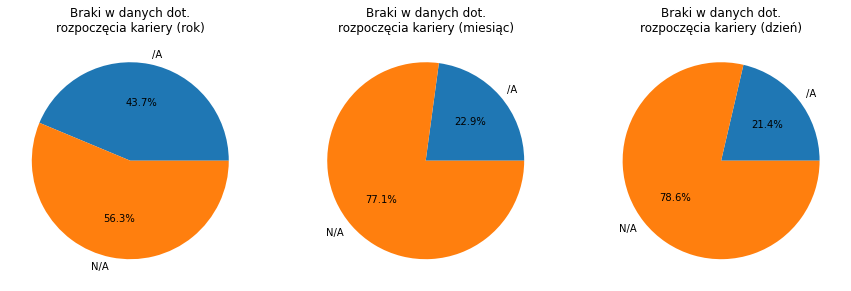

In [202]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')

        SELECT COUNT(*), 'N/A' AS missing FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

        WHERE begin_date_year IS NULL

    UNION

        SELECT COUNT(*), '/A' AS missing FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

        WHERE begin_date_year IS NOT NULL
    
""").set_index('missing').plot.pie(
    title='Braki w danych dot.\nrozpoczęcia kariery (rok)', 
    y='count', autopct='%1.1f%%', ylabel='', legend=False, ax=axes[0]
);

SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')

        SELECT COUNT(*), 'N/A' AS missing FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

        WHERE begin_date_month IS NULL

    UNION

        SELECT COUNT(*), '/A' AS missing FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

        WHERE begin_date_month IS NOT NULL
    
""").set_index('missing').plot.pie(
    title='Braki w danych dot.\nrozpoczęcia kariery (miesiąc)', 
    y='count', autopct='%1.1f%%', ylabel='', legend=False, ax=axes[1]
);

SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')

        SELECT COUNT(*), 'N/A' AS missing FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

        WHERE begin_date_day IS NULL

    UNION

        SELECT COUNT(*), '/A' AS missing FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

        WHERE begin_date_day IS NOT NULL
    
""").set_index('missing').plot.pie(
    title='Braki w danych dot.\nrozpoczęcia kariery (dzień)', 
    y='count', autopct='%1.1f%%', ylabel='', legend=False, ax=axes[2]
);

Jak widać są spore braki w kwesti jednej z ważniejszych danych, czyli tej pierwszej napomkniętej kolumny o rozpoczęciu kariery.

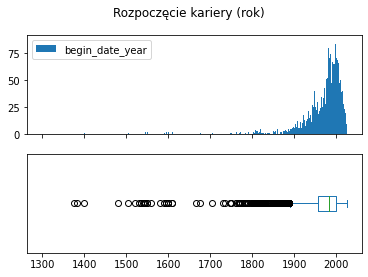

In [226]:
artist_known_init = SQL("""--sql

    WITH pl AS (SELECT area FROM musicbrainz.area_alias WHERE UPPER(name)='POLAND')

        SELECT begin_date_year FROM musicbrainz.artist RIGHT JOIN pl ON pl.area=artist.area

        WHERE artist.begin_date_year IS NOT NULL

""")

fig, axes = plt.subplots(2,1, sharex=True)
artist_known_init.plot.hist(ax=axes[0], bins=range(1300,2025), ylabel='')
artist_known_init.plot.box(ax=axes[1], vert=False, yticks=[])
fig.suptitle('Rozpoczęcie kariery (rok)');

Na podstawie danych możemy przypuszczać, że artyści pochodzą głównie z lat najnowszych. Można to przetestować metodą bootstrap `TODO`